In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

 Load the Data

In [2]:
#specify the columns to use
cols_use_load = ['Date', 'Hour', 'DA_DEMD', 'DryBulb', 'DewPnt', 'Day']
cols_use_price = ['Date', 'Hour', 'DA_DEMD', 'DryBulb', 'DewPnt', 'DA_LMP', 'Day', 'DA_EC', 'DA_CC', 'DA_MLC']

Helper Functions

In [4]:
#functions for converting string to datetime objects
def convert_string_to_datetime(string):
    datetime_obj = datetime.strptime(string, "%d-%b-%y")
    return datetime_obj.date()

#format is different for 2012,2013,2014
def convert_string_to_datetime2(string):
    datetime_obj = datetime.strptime(string, "%m/%d/%Y")
    return datetime_obj.date()

#format is different for 2015
def convert_string_to_datetime3(string):
    datetime_obj = datetime.strptime(string, "%d/%m/%Y")
    return datetime_obj.date()

#format for natural Gas prices
def convert_string_to_datetime4(string):
    datetime_obj = datetime.strptime(string, "%Y-%m-%d")
    return datetime_obj.date()

### Load Complete Data

In [45]:
tot_data = pd.read_csv('../final_complete_data.csv')

In [56]:
#tot_data['Date'] = tot_data['Date'].apply(convert_string_to_datetime4)
tot_data['Date'] = pd.to_datetime(tot_data['Date'])

Deal with missings

In [58]:
X = tot_data.copy()

In [59]:
for i in range(len(X['TARGET_DA_LMP'])):
    if(X['TARGET_DA_LMP'][i] < 1):
        X['TARGET_DA_LMP'][i] = (X['TARGET_DA_LMP'][i-1]+X['TARGET_DA_LMP'][i+1])/2

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Train Test Split

In [60]:
X.set_index('Date', drop=True, inplace=True)

In [61]:
train = X['2012-01-02':'2012-12-31']

In [62]:
test = X['2013-01-01':'2013-12-31']

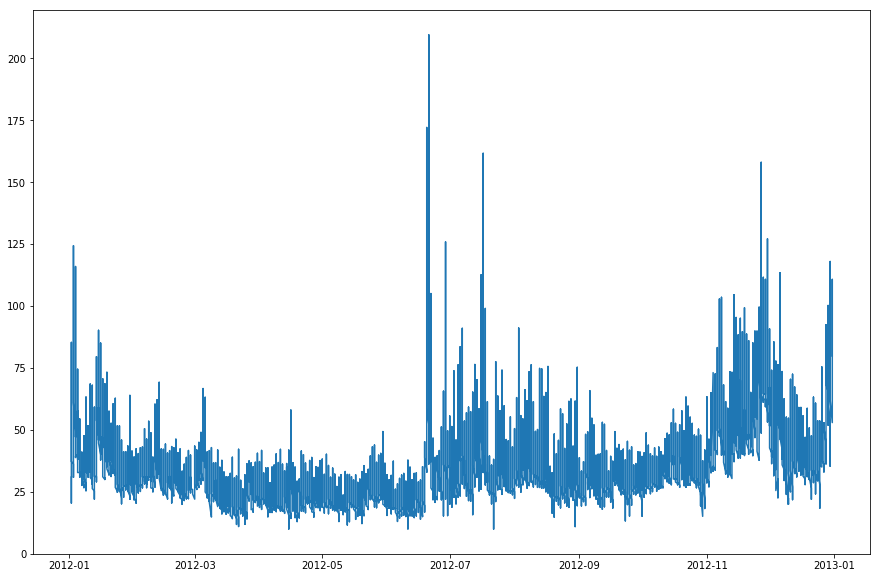

In [63]:
plt.plot(train['TARGET_DA_LMP'])

### Stationarity test

In [64]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [65]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#function to calculate mape
def mean_absolute_percentage_error(y_pred, y_true): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def point_absolute_percentage_error(y_pred, y_true):
    return np.abs((y_true - y_pred) / y_true) * 100

#GIVE Everything you can imagine of function - SD, VAR, MIN and MAX ERROR, CI
def get_CI_VAR_SD(error_list):
    t = stats.t.ppf(1-0.025, len(error_list)-1)
    max_err = np.mean(error_list) + (t * (np.std(error_list)/np.sqrt(len(error_list))))
    min_err = np.mean(error_list) - (t * (np.std(error_list)/np.sqrt(len(error_list))))
    ci = ((max_err - np.mean(error_list))/np.mean(error_list))*100
    sd = np.std(error_list)
    var = np.var(error_list)
    return (max_err, min_err, ci, sd, var)

In [173]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=100)
    rolstd = pd.rolling_std(timeseries, window=100)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=21)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  after removing the cwd from sys.path.
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).std()
  """


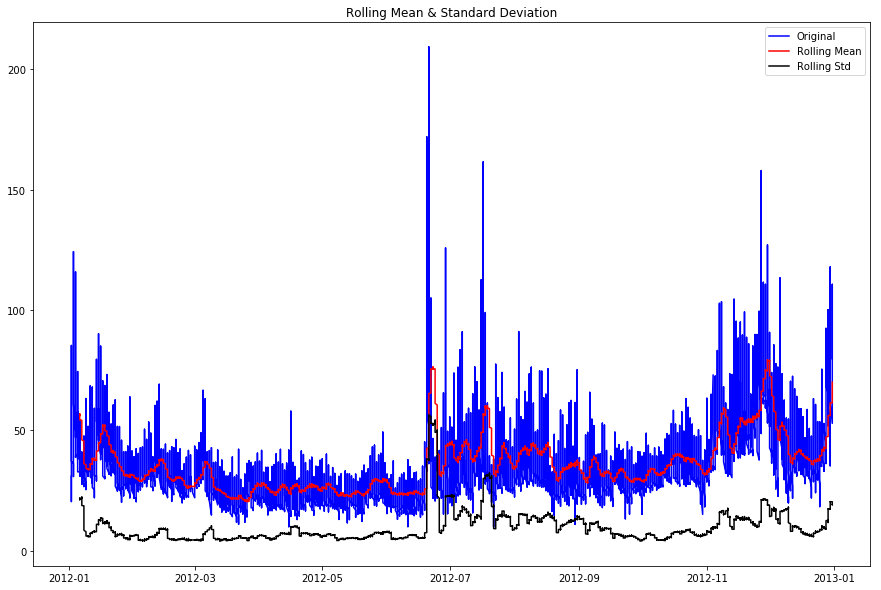

Results of Dickey-Fuller Test:
Test Statistic                   -3.492780
p-value                           0.008174
#Lags Used                       21.000000
Number of Observations Used    8714.000000
Critical Value (1%)              -3.431101
Critical Value (5%)              -2.861872
Critical Value (10%)             -2.566947
dtype: float64


In [174]:
test_stationarity(train['TARGET_DA_LMP'])

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  after removing the cwd from sys.path.
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).std()
  """


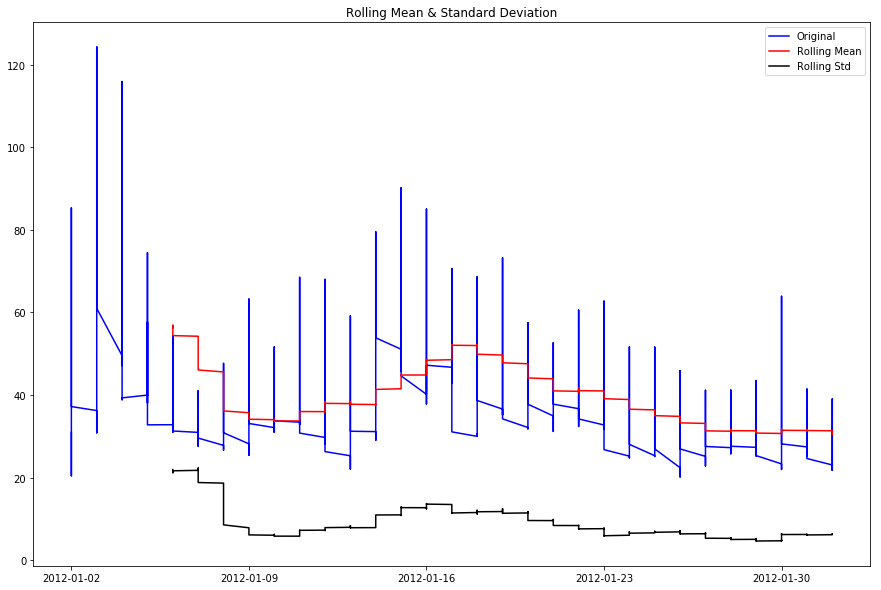

Results of Dickey-Fuller Test:
Test Statistic                  -1.402659
p-value                          0.581001
#Lags Used                      21.000000
Number of Observations Used    722.000000
Critical Value (1%)             -3.439440
Critical Value (5%)             -2.865551
Critical Value (10%)            -2.568906
dtype: float64


In [175]:
test_stationarity(train['TARGET_DA_LMP'][0:24*31])

### MODEL

In [78]:
cond_to_use = ['DA_LMP_actual_value', 'chg_in_da_demd', 'chg_in_da_lmp', 'prev_day_da_lmp', 'DA_LMP_daily_mean',
              'Hour', 'DA_DEMD_actual_value', 'DryBulb_actual_value', 'DryBulb_daily_mean', 'Crude_Oil_Price']
train_x = train[cond_to_use]
test_x = test[cond_to_use]
train_y = train['TARGET_DA_LMP']
test_y = test['TARGET_DA_LMP']

### TRAIN

In [79]:
model = ARIMA(train_y, exog=train_x, order=(0,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:          TARGET_DA_LMP   No. Observations:                 8736
Model:                     ARMA(0, 0)   Log Likelihood              -23799.644
Method:                           css   S.D. of innovations              3.689
Date:                Sat, 23 Feb 2019   AIC                          47623.287
Time:                        03:45:08   BIC                          47708.190
Sample:                    01-02-2012   HQIC                         47652.220
                         - 12-31-2012                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.4180      0.753     -1.883      0.060      -2.894       0.058
DA_LMP_actual_value      0.8523      0.006    147.716      0.000       0.841       0.864
chg_in_da_de

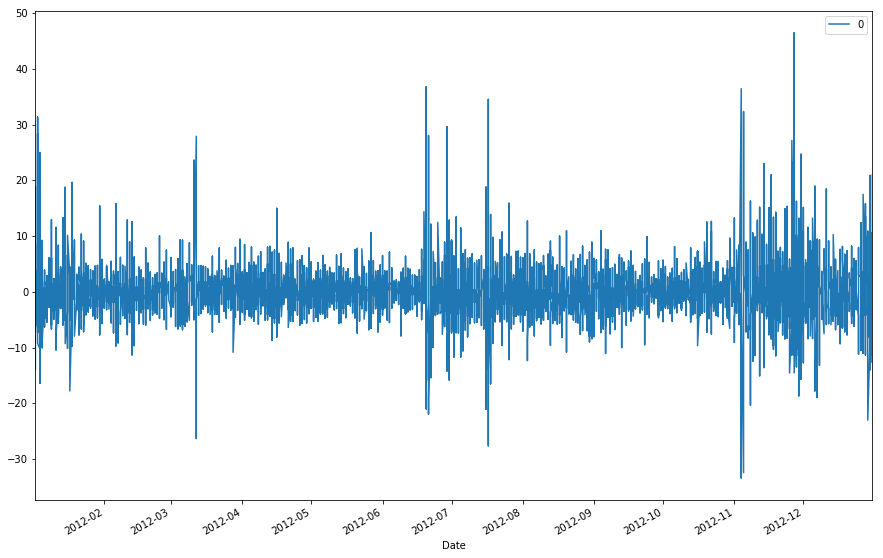

In [80]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

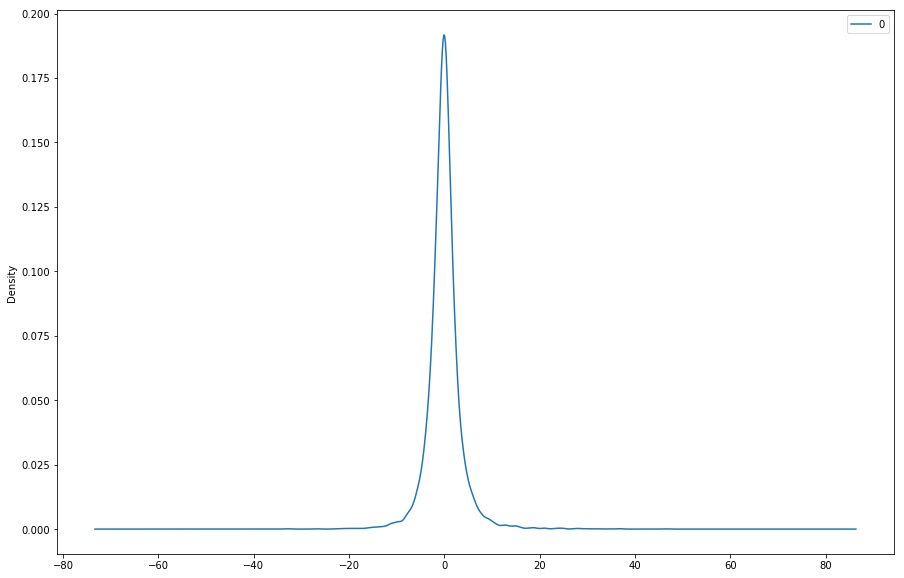

                  0
count  8.736000e+03
mean   1.437810e-08
std    3.689301e+00
min   -3.340176e+01
25%   -1.523412e+00
50%   -8.999740e-02
75%    1.322948e+00
max    4.644754e+01


In [81]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

TRAIN RESULTS

In [82]:
print('MAPE:', mean_absolute_percentage_error(train['TARGET_DA_LMP'].values, model_fit.fittedvalues))
print('MAE:', mean_absolute_error(train['TARGET_DA_LMP'].values, model_fit.fittedvalues))

MAPE: 6.769298810972782
MAE: 2.27655685946


### Iterative Train - Test Process
Daily basis <br>
NEED to convert this to a monthly method -> This will allow trendline comparison

In [86]:
from collections import defaultdict

In [141]:
history_x, history_y = train_x, train_y
prediction_results_history = []
day_wise_mape_history = []
day_wise_mae_history = []

In [142]:
monthly_preds = defaultdict(list)
monthly_mape =  defaultdict(list)

weekly_preds = defaultdict(list)
weekly_mape =  defaultdict(list)

In [143]:
day_count = 1
for i in range(0, len(test_x), 24):
    print(i)
    print(test_x.index[i])
    model = ARIMA(history_y, exog=history_x, order=(0,0,0))
    model_fit = model.fit(disp=0)
    if len(test_x[i:i+24]) == 23:
        output = model_fit.forecast(exog=test_x[i:i+23], steps=23)
    else:
        output = model_fit.forecast(exog=test_x[i:i+24], steps=24)
    mape_day = mean_absolute_percentage_error(test_y[i:i+24].values, output[0])
    mae_day = mean_absolute_error(test_y[i:i+24].values, output[0])
    print('DAY '+str(day_count)+' MAPE: ', mape_day)
    print('DAY '+str(day_count)+' MAE: ', mae_day, end='\n\n\n')
    ### save results to list
    prediction_results_history.extend(output[0])
    history_x.append(test_x[i:i+24])
    history_y.append(test_y[i:i+24])
    day_wise_mape_history.append(mape_day)
    day_wise_mae_history.append(mae_day)
    
    month = test_x.index[i].month
    week = test_x.index[i].week
    
    monthly_mape[month].append(mape_day)
    weekly_mape[week].append(mape_day)
    
    monthly_preds[month].append(output[0])
    weekly_preds[week].append(output[0])
    
    day_count+=1
    if day_count==366:
        break

0
2013-01-01 00:00:00
DAY 1 MAPE:  10.5064182833
DAY 1 MAE:  8.89590666806


24
2013-01-02 00:00:00
DAY 2 MAPE:  7.7909308521
DAY 2 MAE:  7.1405500647


48
2013-01-03 00:00:00
DAY 3 MAPE:  6.71850113633
DAY 3 MAE:  5.54289691721


72
2013-01-04 00:00:00
DAY 4 MAPE:  5.88562783494
DAY 4 MAE:  3.88392057776


96
2013-01-05 00:00:00
DAY 5 MAPE:  6.18420482752
DAY 5 MAE:  3.16325514831


120
2013-01-06 00:00:00
DAY 6 MAPE:  5.54063977723
DAY 6 MAE:  2.54303502191


144
2013-01-07 00:00:00
DAY 7 MAPE:  7.00368629562
DAY 7 MAE:  3.69137703141


168
2013-01-08 00:00:00
DAY 8 MAPE:  5.60060309484
DAY 8 MAE:  2.24025016823


192
2013-01-09 00:00:00
DAY 9 MAPE:  4.84720950942
DAY 9 MAE:  2.00619445965


216
2013-01-10 00:00:00
DAY 10 MAPE:  5.88453352626
DAY 10 MAE:  2.19666180764


240
2013-01-11 00:00:00
DAY 11 MAPE:  4.50258104851
DAY 11 MAE:  1.48066904856


264
2013-01-12 00:00:00
DAY 12 MAPE:  14.2017352032
DAY 12 MAE:  6.13453811497


288
2013-01-13 00:00:00
DAY 13 MAPE:  7.5226345072
DAY

DAY 103 MAPE:  6.70585012329
DAY 103 MAE:  2.48543252138


2472
2013-04-14 00:00:00
DAY 104 MAPE:  4.11095296352
DAY 104 MAE:  1.72972524798


2496
2013-04-15 00:00:00
DAY 105 MAPE:  6.67712841265
DAY 105 MAE:  3.09055568595


2520
2013-04-16 00:00:00
DAY 106 MAPE:  4.30765663911
DAY 106 MAE:  1.72890441424


2544
2013-04-17 00:00:00
DAY 107 MAPE:  3.4752481788
DAY 107 MAE:  1.41285013213


2568
2013-04-18 00:00:00
DAY 108 MAPE:  4.77872676952
DAY 108 MAE:  2.07329252281


2592
2013-04-19 00:00:00
DAY 109 MAPE:  5.1984972187
DAY 109 MAE:  2.10985452968


2616
2013-04-20 00:00:00
DAY 110 MAPE:  5.35382487013
DAY 110 MAE:  2.19742718383


2640
2013-04-21 00:00:00
DAY 111 MAPE:  4.45715017159
DAY 111 MAE:  1.92081849954


2664
2013-04-22 00:00:00
DAY 112 MAPE:  6.6134791193
DAY 112 MAE:  2.97186026275


2688
2013-04-23 00:00:00
DAY 113 MAPE:  3.95806456236
DAY 113 MAE:  1.85555405956


2712
2013-04-24 00:00:00
DAY 114 MAPE:  1.98904066256
DAY 114 MAE:  0.840100278253


2736
2013-04-25 00:

DAY 201 MAPE:  12.4687558676
DAY 201 MAE:  6.67225934575


4824
2013-07-21 00:00:00
DAY 202 MAPE:  9.55406692527
DAY 202 MAE:  4.23561595844


4848
2013-07-22 00:00:00
DAY 203 MAPE:  5.7118915674
DAY 203 MAE:  2.54604402998


4872
2013-07-23 00:00:00
DAY 204 MAPE:  3.95621915659
DAY 204 MAE:  1.80785047109


4896
2013-07-24 00:00:00
DAY 205 MAPE:  4.34994606202
DAY 205 MAE:  2.00796063154


4920
2013-07-25 00:00:00
DAY 206 MAPE:  4.75750198248
DAY 206 MAE:  1.82043152509


4944
2013-07-26 00:00:00
DAY 207 MAPE:  2.56961484749
DAY 207 MAE:  0.827771940899


4968
2013-07-27 00:00:00
DAY 208 MAPE:  4.91077342858
DAY 208 MAE:  1.55829576747


4992
2013-07-28 00:00:00
DAY 209 MAPE:  3.94887793158
DAY 209 MAE:  1.35437443232


5016
2013-07-29 00:00:00
DAY 210 MAPE:  4.3829778983
DAY 210 MAE:  1.95101251832


5040
2013-07-30 00:00:00
DAY 211 MAPE:  6.15772425243
DAY 211 MAE:  2.15597109841


5064
2013-07-31 00:00:00
DAY 212 MAPE:  3.09326675774
DAY 212 MAE:  1.17929375236


5088
2013-08-01 00

DAY 299 MAPE:  6.70961239449
DAY 299 MAE:  2.24555300862


7176
2013-10-27 00:00:00
DAY 300 MAPE:  4.99088989295
DAY 300 MAE:  1.59991697448


7200
2013-10-28 00:00:00
DAY 301 MAPE:  4.85465836189
DAY 301 MAE:  1.74169970939


7224
2013-10-29 00:00:00
DAY 302 MAPE:  4.07704781645
DAY 302 MAE:  1.6359671517


7248
2013-10-30 00:00:00
DAY 303 MAPE:  4.72889115224
DAY 303 MAE:  1.90842377516


7272
2013-10-31 00:00:00
DAY 304 MAPE:  5.3382110802
DAY 304 MAE:  2.07154444841


7296
2013-11-01 00:00:00
DAY 305 MAPE:  5.19392700298
DAY 305 MAE:  1.93794108972


7320
2013-11-02 00:00:00
DAY 306 MAPE:  8.75644025066
DAY 306 MAE:  2.97242366246


7344
2013-11-03 00:00:00
DAY 307 MAPE:  13.6548297173
DAY 307 MAE:  4.88344256563


7368
2013-11-04 00:00:00
DAY 308 MAPE:  112.284343249
DAY 308 MAE:  5.66094193465


7392
2013-11-05 00:00:00
DAY 309 MAPE:  6.38675511862
DAY 309 MAE:  2.19605520764


7416
2013-11-06 00:00:00
DAY 310 MAPE:  8.00741409603
DAY 310 MAE:  2.95702848027


7440
2013-11-07 00:

In [144]:
len(prediction_results_history)

8759

In [155]:
test['Predicted_Values'] = prediction_results_history

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [158]:
test.shape

(8759, 26)

In [157]:
test.head()

,Hour,DA_DEMD_actual_value,DA_LMP_actual_value,DA_EC,DA_CC,DA_MLC,DryBulb_actual_value,DewPnt_actual_value,Day,Day_Date,...,chg_in_dry_bulb,DA_DEMD_daily_mean,DA_LMP_daily_mean,DryBulb_daily_mean,DewPnt_daily_mean,Crude_Oil_Price,Crude_Oil_Vol,Natural_Gas_Price_Open,Natural_Gas_Price_Close,Predicted_Values
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,11828.0,79.80,79.34,0.0,0.46,33.0,22.0,3.0,1.0,...,0.0,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,74.311308
2013-01-01,2.0,11785.0,66.28,65.81,0.0,0.47,33.0,22.0,3.0,1.0,...,0.0,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,67.807275
2013-01-01,3.0,11600.0,68.89,68.47,0.0,0.42,33.0,22.0,3.0,1.0,...,-1.0,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,70.828598
2013-01-01,4.0,11252.0,50.22,50.01,0.0,0.21,34.0,22.0,3.0,1.0,...,1.0,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,56.250944
2013-01-01,5.0,11399.0,51.67,51.47,0.0,0.20,33.0,22.0,3.0,1.0,...,0.0,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,60.422118


In [160]:
test.to_csv('prediction_results_exogenous_arima.csv', index=True)

 ### TEST Performances

In [85]:
np.mean(day_wise_mape_history)

7.5317557025663255

In [32]:
np.mean(day_wise_mape_history[len(day_wise_mape_history)-31:-1])

8.244839516709586

In [33]:
np.mean(day_wise_mape_history[0:30])

7.7521586274604362

In [34]:
np.mean(day_wise_mae_history)

4.0962530921211684

In [122]:
len(prediction_results_history)/2

8736.0

In [123]:
test_x.shape

(8759, 10)

In [164]:
[0 for i in range(12)]+[np.mean(i) for i in monthly_mape.values()]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7.9269005214909454,
 11.126756527871496,
 12.217002485739069,
 5.4707438795196408,
 4.5083083713256382,
 5.3083228708401187,
 6.0863018764643186,
 4.9026593471824054,
 8.3903802546765469,
 5.6799117968919886,
 10.870428508294866,
 8.2196814845742914]

Average Monthly MAPE

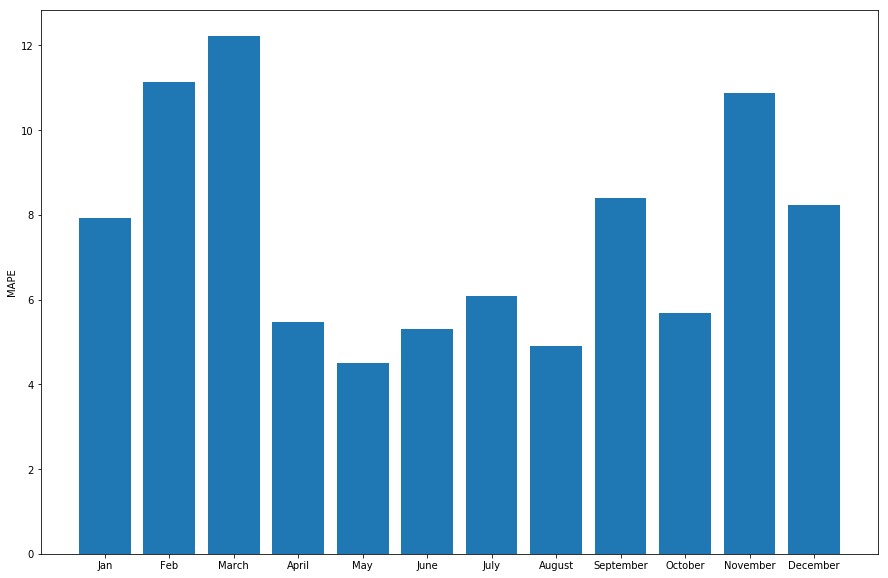

In [153]:
plt.bar(np.arange(12),[np.mean(i) for i in monthly_mape.values()])
plt.xticks(np.arange(12), ('Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
                          'November', 'December'))
plt.ylabel('MAPE')
plt.show()